In [1]:
library('igraph')
library('clevr')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




### Question 2
Plot the histogram showing the un-normalized distribution of edge weghts

In [2]:
calculate_weights <- function(edge_weight_file, log_norm_mat, tickers_sectors) {
  cat("Source", "\t", "Sink", "\t", "Weight", file = edge_weight_file)
  num_rows <- dim(log_norm_mat)[1]
  for (i in 1:(num_rows - 1)) {
    for (j in (i + 1):num_rows) {
      ri <- mean(log_norm_mat[i,])
      rj <- mean(log_norm_mat[j,])
      ri2 <- log_norm_mat[i,] ^ 2
      rj2 <- log_norm_mat[j,] ^ 2
      rhoij <- (mean(log_norm_mat[i,] * log_norm_mat[j,]) - (ri * rj)) / sqrt((mean(ri2) - (ri ^ 2)) * (mean(rj2) - (rj ^ 2)))
      wij <- sqrt(2 * (1 - rhoij))
      cat('\n', tickers_sectors[i, 1], '\t', tickers_sectors[j, 1], '\t', wij, file = edge_weight_file)
    }
  }
}

In [3]:
tickers_sectors <- read.csv('finance_data/Name_sector.csv', header = TRUE, stringsAsFactors = FALSE)
filenames <- list.files('finance_data/data', pattern = "\\.csv$", full.names = TRUE)

length_data <- numeric(length(filenames))
log_norm_mat <- matrix(0, length(filenames) - 11, 764)
valid_file_count <- 1

for (j in seq_along(filenames)) {
  df <- read.csv(filenames[j], header = TRUE, stringsAsFactors = FALSE)
  length_data[j] <- nrow(df)
  
  if (length_data[j] == 765) {
    p <- df[, 5]
    q <- diff(p) / head(p, -1)
    r <- log(1 + q)
    log_norm_mat[valid_file_count, ] <- r
    valid_file_count <- valid_file_count + 1
  }
}

tickers_sectors <- tickers_sectors[length_data == 765, ]
edge_weight_file <- file("finance_data/edge_weights.txt", "w")
calculate_weights(edge_weight_file, log_norm_mat, tickers_sectors)
close(edge_weight_file)

edge_list <- read.delim("finance_data/edge_weights.txt", header = TRUE)
correlation_graph <- graph.data.frame(edge_list, directed = FALSE)
E(correlation_graph)$weight <- edge_list[,"Weight"]

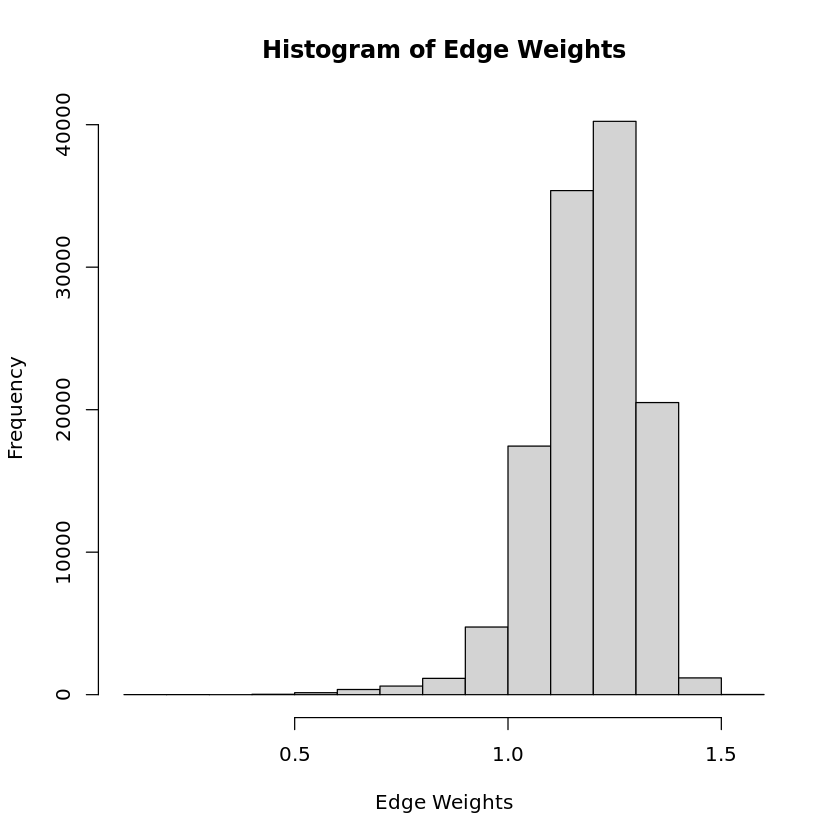

In [4]:
hist(edge_list[,"Weight"], main = "Histogram of Edge Weights", xlab = "Edge Weights", ylab = "Frequency")


### Question 3
Extract the MST of the correlation graph. Each stock can be categorized into a sector, which can be found in `Name_sector.csv` file. Plot the MST and color-code the nodes based on sectors. Do you see any pattern in the MST? The structure that you find in MST are called Vine clusters. Provide a detailed explanation about the pattern you observe.

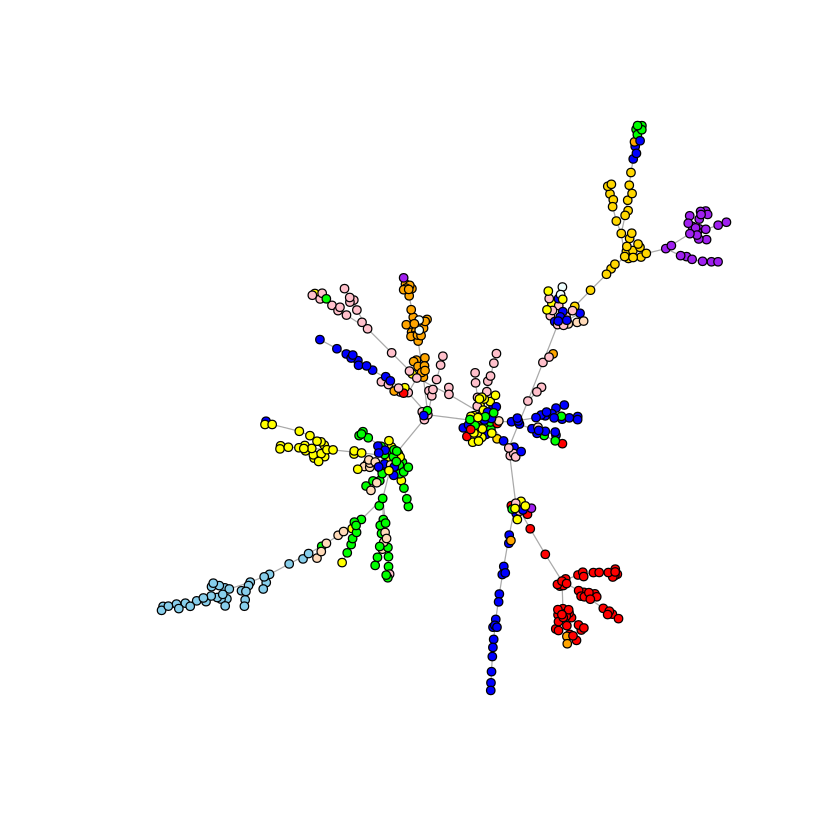

In [5]:
mst <- mst(correlation_graph, algorithm = "prim")
sectors <- unique(tickers_sectors[, 2])

vertex_colors <- sapply(V(correlation_graph), function(v) {
  sector_index <- which(sectors == tickers_sectors[v, 2])
  colors <- c("red", "green", "blue", "yellow", "orange", "purple", "pink", "gold", "peachpuff", "skyblue", "azure")
  colors[sector_index]
})

plot(mst, vertex.size = 3, vertex.label = NA, vertex.color = vertex_colors)

### Question 4
Run a community detection algoirthm (for example walktrap) on the MST obtained above. Plot the communities formed. Compute the homogeneity and completeness of the clustering. (you can use the `clevr` library in r to compute homogeneity and completeness).

Homogeneity: 0.6826446 
Completeness: 0.4792845 


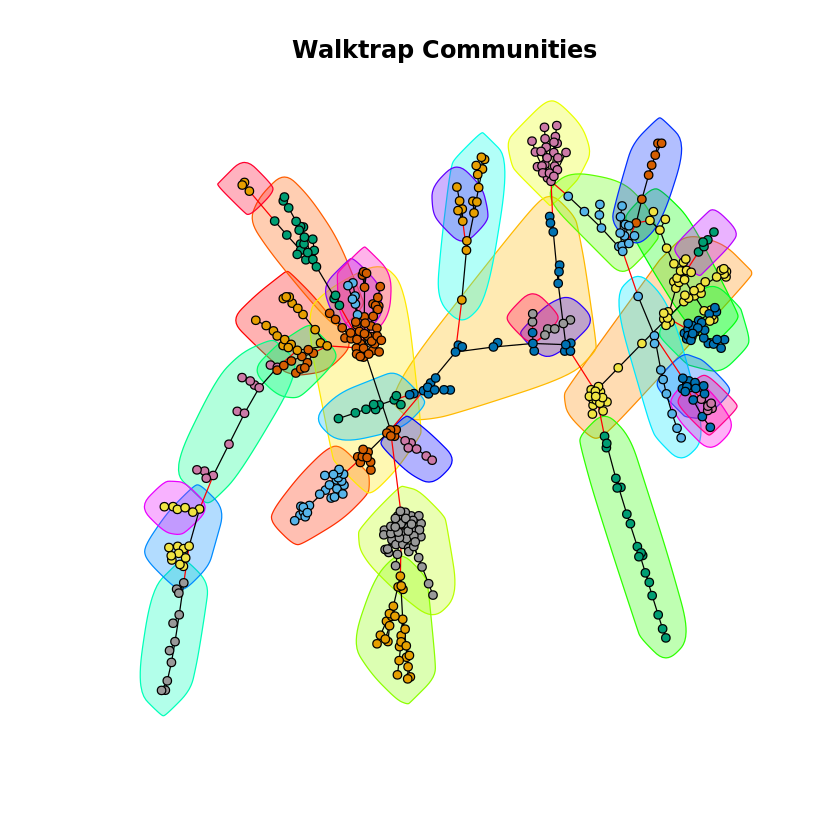

In [6]:
walktrap_communities <- cluster_walktrap(mst)
plot(walktrap_communities, mst, vertex.label = NA, vertex.size = 3, main = "Walktrap Communities")

sector_labels <- tickers_sectors[, 2]
membership_vector <- membership(walktrap_communities)
membership_numeric <- as.numeric(membership_vector)
sector_numeric <- as.numeric(factor(sector_labels))

homogeneity_score <- clevr::homogeneity(sector_numeric, membership_numeric)
completeness_score <- clevr::completeness(sector_numeric, membership_numeric)

cat("Homogeneity:", homogeneity_score, "\n")
cat("Completeness:", completeness_score, "\n")

### Question 5
Repor the value of $\alpha$ for the above two cases and provide an interpretation for the difference

In [7]:
sector_counts <- sapply(sectors, function(sector) sum(tickers_sectors[, 2] == sector))
p1 <- numeric(vcount(mst))
p2 <- numeric(vcount(mst))

for (v in V(mst)) {
  neighbors_v <- neighbors(mst, v)
  num_neighbors <- length(neighbors_v)
  same_sector_count <- sum(tickers_sectors[neighbors_v, 2] == tickers_sectors[v, 2])
  p1[v] <- same_sector_count / num_neighbors
  p2[v] <- sector_counts[tickers_sectors[v, 2]] / vcount(mst)
}

alpha1 <- mean(p1)
alpha2 <- mean(p2)
cat(sprintf("Alpha values: %f and %f", alpha1, alpha2), "\n")

Alpha values: 0.828930 and 0.114188 


### Question 6
Repeat questions 2,3,4,5 on the WEEKLY data.

In [10]:
tickers_sectors_week <- read.csv('finance_data/Name_sector.csv', header = TRUE, stringsAsFactors = FALSE)
filenames_week <- list.files('finance_data/data', pattern = "\\.csv$", full.names = TRUE)

length_data_week <- numeric(length(filenames_week))
log_norm_mat_week <- matrix(0, length(filenames_week) - 13, 142)
valid_file_count <- 1

for (j in seq_along(filenames_week)) {
  df <- read.csv(filenames_week[j], header = TRUE, stringsAsFactors = FALSE)
  df$Day <- weekdays(as.Date(df[, 1]))
  df <- subset(df, Day == 'Monday')
  length_data_week[j] <- nrow(df)
  
  if (length_data_week[j] == 143) {
    p <- df[, 5]
    q <- diff(p) / head(p, -1)
    r <- log(1 + q)
    log_norm_mat_week[valid_file_count, ] <- r
    valid_file_count <- valid_file_count + 1
  }
}

tickers_sectors_week <- tickers_sectors_week[length_data_week == 143, ]
edge_weight_file_week <- file("finance_data/edge_weights_week.txt", "w")
calculate_weights(edge_weight_file_week, log_norm_mat_week, tickers_sectors_week)
close(edge_weight_file_week)

edge_list_week <- read.delim("finance_data/edge_weights_week.txt", header = TRUE)
correlation_graph_week <- graph.data.frame(edge_list_week, directed = FALSE)
E(correlation_graph_week)$weight <- edge_list_week[,"Weight"]

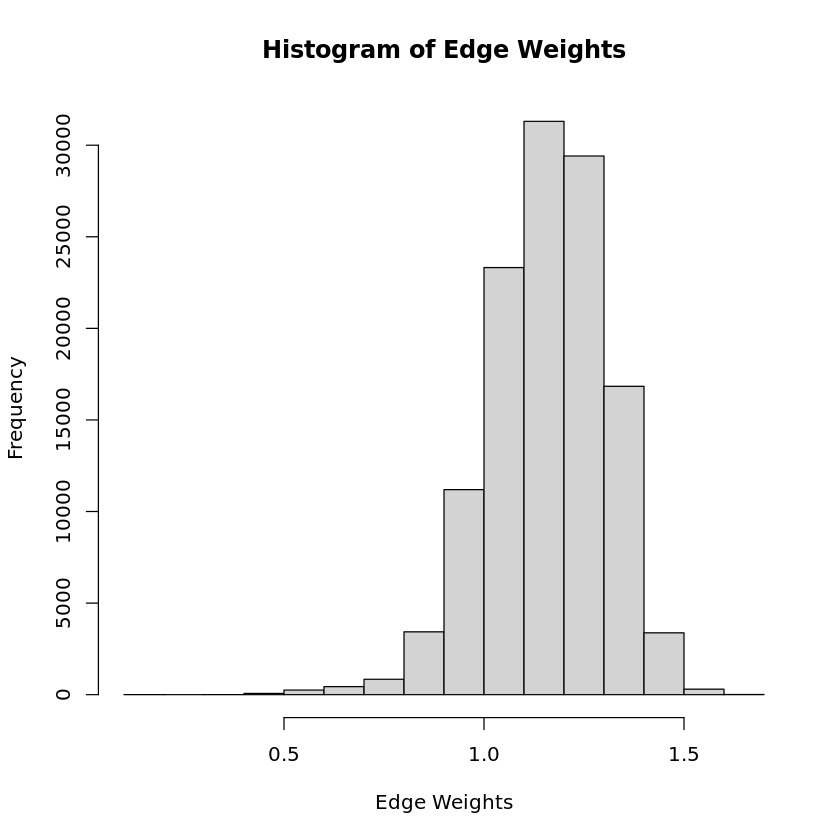

In [11]:
hist(edge_list_week[,"Weight"], main = "Histogram of Edge Weights", xlab = "Edge Weights", ylab = "Frequency")


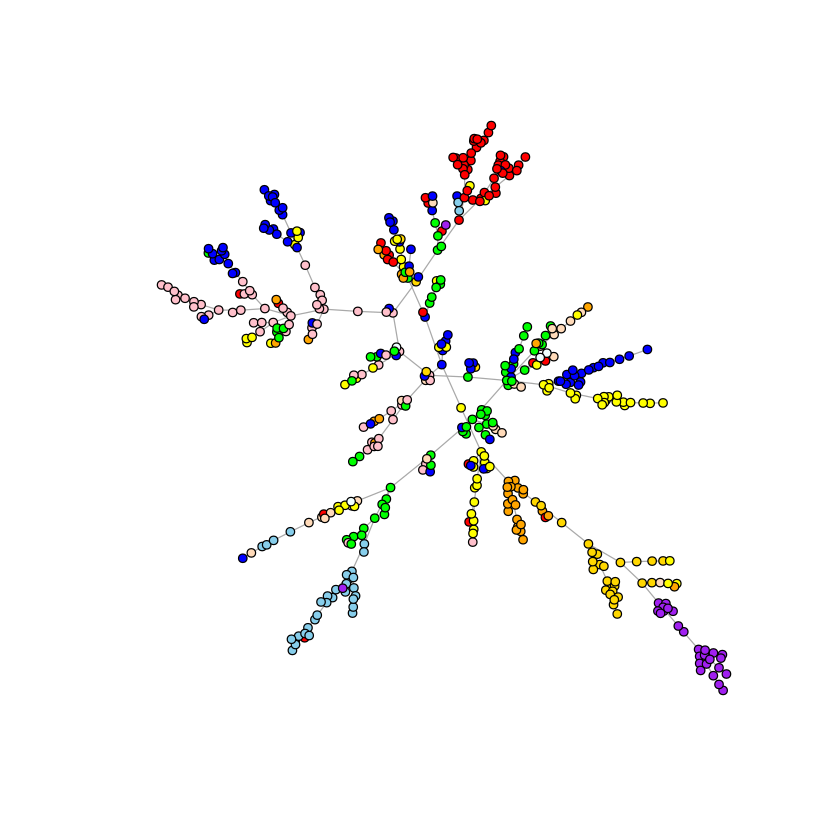

In [12]:
mst_week <- mst(correlation_graph_week, algorithm = "prim")
sectors_week <- unique(tickers_sectors_week[, 2])

vertex_colors_week <- sapply(V(correlation_graph_week), function(v) {
  sector_index <- which(sectors_week == tickers_sectors_week[v, 2])
  colors <- c("red", "green", "blue", "yellow", "orange", "purple", "pink", "gold", "peachpuff", "skyblue", "azure")
  colors[sector_index]
})

plot(mst_week, vertex.size = 3, vertex.label = NA, vertex.color = vertex_colors_week)

Homogeneity: 0.5811237 
Completeness: 0.3900435 


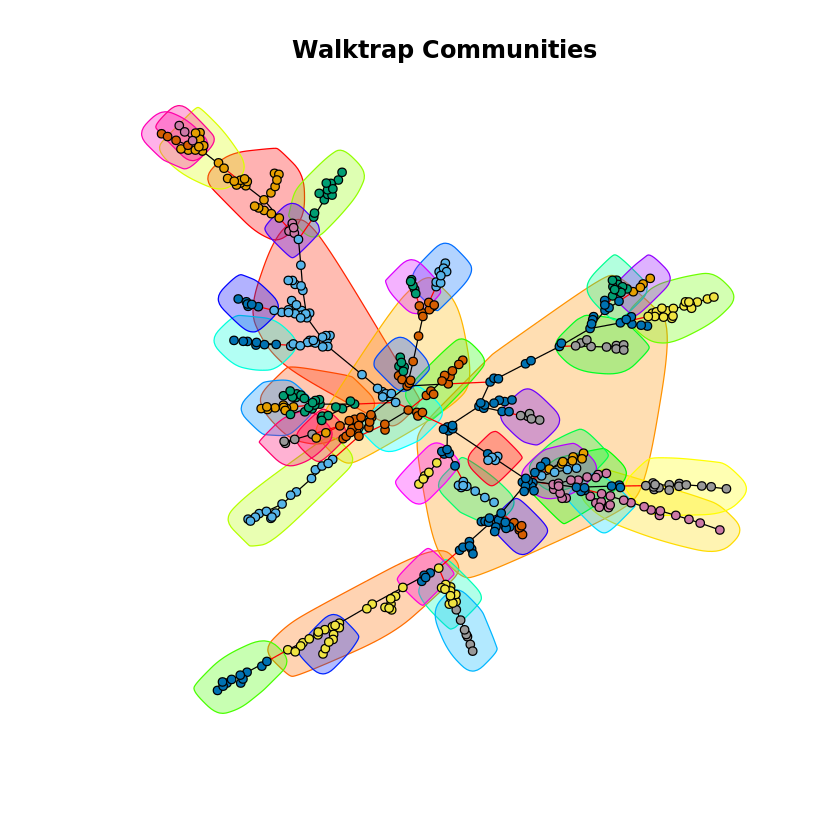

In [13]:
walktrap_communities_week <- cluster_walktrap(mst_week)
plot(walktrap_communities_week, mst_week, vertex.label = NA, vertex.size = 3, main = "Walktrap Communities")

sector_labels_week <- tickers_sectors_week[, 2]
membership_vector_week <- membership(walktrap_communities_week)
membership_numeric_week <- as.numeric(membership_vector_week)
sector_numeric_week <- as.numeric(factor(sector_labels_week))

homogeneity_score_week <- clevr::homogeneity(sector_numeric_week, membership_numeric_week)
completeness_score_week <- clevr::completeness(sector_numeric_week, membership_numeric_week)

cat("Homogeneity:", homogeneity_score_week, "\n")
cat("Completeness:", completeness_score_week, "\n")

In [14]:
sector_counts_week <- sapply(sectors_week, function(sector) sum(tickers_sectors_week[, 2] == sector))
p1_week <- numeric(vcount(mst_week))
p2_week <- numeric(vcount(mst_week))

for (v in V(mst_week)) {
  neighbors_v <- neighbors(mst_week, v)
  num_neighbors <- length(neighbors_v)
  same_sector_count <- sum(tickers_sectors_week[neighbors_v, 2] == tickers_sectors_week[v, 2])
  p1_week[v] <- same_sector_count / num_neighbors
  p2_week[v] <- sector_counts_week[tickers_sectors_week[v, 2]] / vcount(mst_week)
}

alpha1_week <- mean(p1_week)
alpha2_week <- mean(p2_week)
cat(sprintf("Alpha values: %f and %f", alpha1_week, alpha2_week), "\n")

Alpha values: 0.743957 and 0.114309 


### Question 7
Repeat questions 2,3,4,5 on the MONTHLY data.

In [15]:
tickers_sectors_month <- read.csv('finance_data/Name_sector.csv', header = TRUE, stringsAsFactors = FALSE)
filenames_month <- list.files('finance_data/data', pattern = "\\.csv$", full.names = TRUE)

length_data_month <- numeric(length(filenames_month))
log_norm_mat_month <- matrix(0, length(filenames_month) - 13, 24)
valid_file_count <- 1

for (j in seq_along(filenames_month)) {
  df <- read.csv(filenames_month[j], header = TRUE, stringsAsFactors = FALSE)
  df$Day <- as.Date(df[, 1])
  df$DayOfMonth <- format(df$Day, "%d")
  df <- subset(df, DayOfMonth == '15')
  length_data_month[j] <- nrow(df)
  
  if (length_data_month[j] == 25) {
    p <- df[, 5]
    q <- diff(p) / head(p, -1)
    r <- log(1 + q)
    log_norm_mat_month[valid_file_count, ] <- r
    valid_file_count <- valid_file_count + 1
  }
}

tickers_sectors_month <- tickers_sectors_month[length_data_month == 25, ]
edge_weight_file_month <- file("finance_data/edge_weights_month.txt", "w")
calculate_weights(edge_weight_file_month, log_norm_mat_month, tickers_sectors_month)
close(edge_weight_file_month)

edge_list_month <- read.delim("finance_data/edge_weights_month.txt", header = TRUE)
correlation_graph_month <- graph.data.frame(edge_list_month, directed = FALSE)
E(correlation_graph_month)$weight <- edge_list_month[,"Weight"]

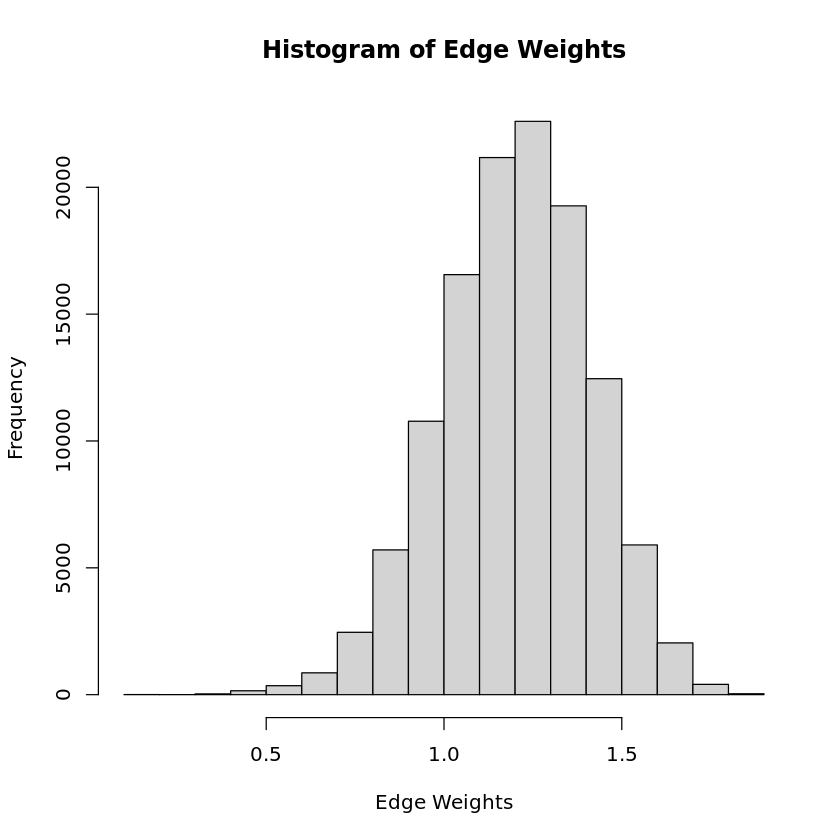

In [16]:
hist(edge_list_month[,"Weight"], main = "Histogram of Edge Weights", xlab = "Edge Weights", ylab = "Frequency")


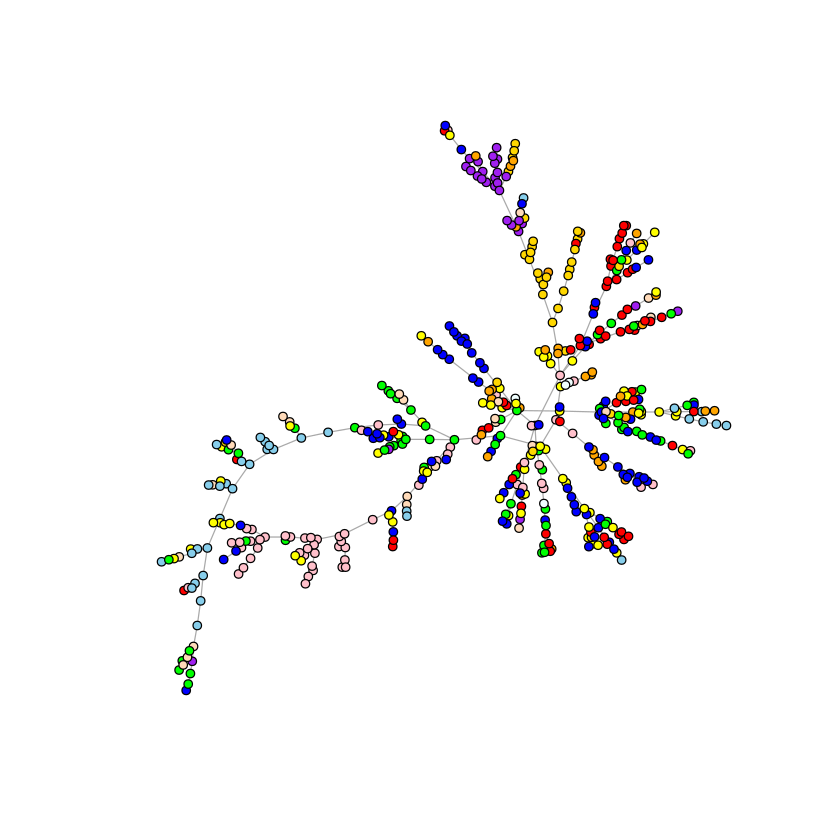

In [17]:
mst_month <- mst(correlation_graph_month, algorithm = "prim")
sectors_month <- unique(tickers_sectors_month[, 2])

vertex_colors_month <- sapply(V(correlation_graph_month), function(v) {
  sector_index <- which(sectors_month == tickers_sectors_month[v, 2])
  colors <- c("red", "green", "blue", "yellow", "orange", "purple", "pink", "gold", "peachpuff", "skyblue", "azure")
  colors[sector_index]
})

plot(mst_month, vertex.size = 3, vertex.label = NA, vertex.color = vertex_colors_month)

Homogeneity: 0.4794473 
Completeness: 0.2775512 


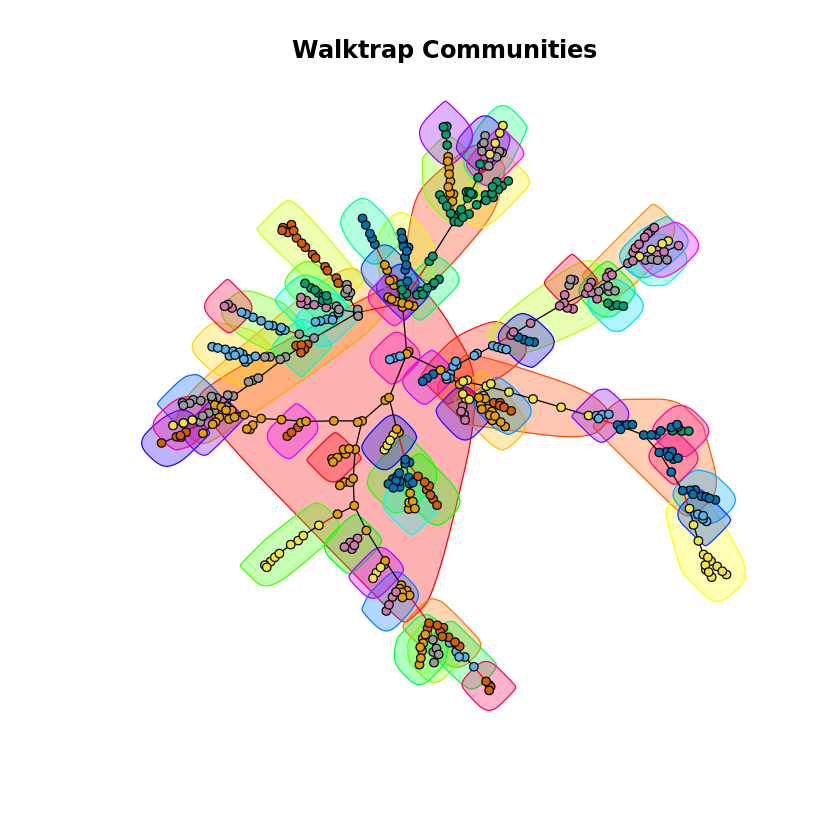

In [19]:
walktrap_communities_month <- cluster_walktrap(mst_month)
plot(walktrap_communities_month, mst_month, vertex.label = NA, vertex.size = 3, main = "Walktrap Communities")

sector_labels_month <- tickers_sectors_month[, 2]
membership_vector_month <- membership(walktrap_communities_month)
membership_numeric_month <- as.numeric(membership_vector_month)
sector_numeric_month <- as.numeric(factor(sector_labels_month))

homogeneity_score_month <- clevr::homogeneity(sector_numeric_month, membership_numeric_month)
completeness_score_month <- clevr::completeness(sector_numeric_month, membership_numeric_month)

cat("Homogeneity:", homogeneity_score_month, "\n")
cat("Completeness:", completeness_score_month, "\n")

In [20]:
sector_counts_month <- sapply(sectors_month, function(sector) sum(tickers_sectors_month[, 2] == sector))
p1_month <- numeric(vcount(mst_month))
p2_month <- numeric(vcount(mst_month))

for (v in V(mst_month)) {
  neighbors_v <- neighbors(mst_month, v)
  num_neighbors <- length(neighbors_v)
  same_sector_count <- sum(tickers_sectors_month[neighbors_v, 2] == tickers_sectors_month[v, 2])
  p1_month[v] <- same_sector_count / num_neighbors
  p2_month[v] <- sector_counts_month[tickers_sectors_month[v, 2]] / vcount(mst_month)
}

alpha1_month <- mean(p1_month)
alpha2_month <- mean(p2_month)
cat(sprintf("Alpha values: %f and %f", alpha1_month, alpha2_month), "\n")

Alpha values: 0.484446 and 0.114309 
